In [58]:
import random
import numpy as np
from game import Game, Move, Player
from copy import deepcopy
from tqdm import tqdm

border = []
for i in range(5):
    for j in range(5):
        if i == 0 or i == 4 or j == 0 or j == 4:
            border.append((i, j))
BORDER = (list(set(border)))
print(len(BORDER))

ALL_MOVES = []
for pos in BORDER:
    possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
    if pos[0] == 0: possible_moves.remove(Move.LEFT)
    if pos[0] == 4: possible_moves.remove(Move.RIGHT)
    if pos[1] == 0: possible_moves.remove(Move.TOP)
    if pos[1] == 4: possible_moves.remove(Move.BOTTOM)

    for move in possible_moves: ALL_MOVES.append((pos, move))
N_ALL = len(ALL_MOVES)

class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        from_pos = random.choice(BORDER)
        while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

        possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
        if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
        if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
        if from_pos[1] == 0: possible_moves.remove(Move.TOP)
        if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
        
        move = random.choice(possible_moves)

        return from_pos, move

16


In [59]:
class ID_generator:
    def __init__(self):
        self.id = -1
    def get_id(self):
        self.id += 1
        return self.id

In [60]:
def rot(n_rot):
    def rot_n(board): 
        return np.rot90(board, k= n_rot)
    return rot_n

def flip_rot(n_rot):
    def flip_rot_n(board): 
        return np.rot90(np.fliplr(board), k= n_rot)
    return flip_rot_n

rot2 = rot(2)
rot3 = rot(3)
flip_rot1 = flip_rot(1)
flip_rot2 = flip_rot(2)
flip_rot3 = flip_rot(3)

In [61]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [62]:
# weight definition
INPUT_SHAPE = (24, 5, 5)
WEIGHT_SHAPE = np.array([
    [
        ('dense', 256),
        ('dense', 128),
        ('dense', 64),
        ('dense', N_ALL),
    ],
    [
        ('dense', 128),
        ('dense', 64),
        ('dense', N_ALL),
    ],
    [
        ('dense', 128),
        ('dense', 64),
        ('dense', N_ALL),
    ],
], dtype= object)

def multiply(x):
    res = 1
    for xx in x: res *= xx
    return res

class MyPlayer(Player):
    def __init__(self, id, heritage= None) -> None:
        super().__init__()

        self.id = id

        if heritage is None:
            self.W = []
            self.b = []

            for branch in WEIGHT_SHAPE:
                branch_w = []
                branch_b = []
                in_shape = INPUT_SHAPE

                for layer in branch:
                    #print(in_shape)
                    #print(layer)

                    if layer[0] == 'dense':
                        in_shape = multiply(in_shape)
                        branch_w.append(np.random.random(size= (in_shape, layer[1])))
                        branch_b.append(np.random.random(size= (layer[1],)))
                        in_shape = (layer[1],)

                    elif layer[0] == 'conv':

                        if len(in_shape) == 2:
                            branch_w.append(np.random.random(size= layer[1]))
                            branch_b.append(np.random.random(size= (layer[1][0],)))
                            in_shape = (layer[1][0], in_shape[0] - layer[1][1] + 1, in_shape[1] - layer[1][2] + 1)

                        else:
                            branch_w.append(np.random.random(size= (layer[1][0] * in_shape[0], layer[1][1], layer[1][2])))
                            branch_b.append(np.random.random(size= (layer[1][0] * in_shape[0],)))
                            in_shape = (layer[1][0] * in_shape[0], in_shape[1] - layer[1][1] + 1, in_shape[2] - layer[1][2] + 1)

                    else: print('error')

                    #print(branch_w[-1].shape)
                    #print(branch_b[-1].shape)
                    #print('-')

                    #print(in_shape)
                #print('-----')

                self.W.append(branch_w)
                self.b.append(branch_b)

            self.W = np.array(self.W, dtype= object)
            self.b = np.array(self.b, dtype= object)

        else:
            self.W = heritage[0]
            self.b = heritage[1]

        self.fitness = 0
        self.until_surrend = 100
        self.epoch_before_death = 3

    def get_id(self): return self.id
    def reset_fitness(self) -> None: self.fitness = 0
    def mod_fitness(self, mod) -> None: self.fitness += mod
    def get_fitness(self): return self.fitness
    def set_fitness(self, new_value) -> None: self.fitness = new_value
    def get_weights(self): return self.W
    def get_biases(self): return self.b
    def prepare_to_surrend(self, amount= 100)-> None: self.until_surrend = amount
    def get_death(self, bonus= None):
        if bonus is not None: self.epoch_before_death = bonus + 1
        self.epoch_before_death -= 1
        return self.epoch_before_death
    
    def compute_move(self, X):
        branch_outputs = []

        for i_branch in range(len(self.W)):
            layer_input = deepcopy(X)

            for i_layer in range(len(self.W[i_branch])):
                layer_info = WEIGHT_SHAPE[i_branch][i_layer]

                if layer_info[0] == 'dense':
                    layer_output = np.dot(layer_input.flatten(), self.W[i_branch][i_layer]) + self.b[i_branch][i_layer]
                
                elif layer_info[0] == 'conv':

                    if len(layer_input.shape) == 2:
                        layer_output = np.zeros((layer_info[1][0], layer_input.shape[0] - layer_info[1][1] + 1, layer_input.shape[1] - layer_info[1][2] + 1))
                        for k in range(layer_output.shape[0]):
                            for i in range(layer_output.shape[1]):
                                for j in range(layer_output.shape[2]):
                                    layer_output[k, i, j] = sum(sum(layer_input[i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k]))
                    
                    else:
                        layer_output = np.zeros((layer_info[1][0] * layer_input.shape[0], layer_input.shape[1] - layer_info[1][1] + 1, layer_input.shape[2] - layer_info[1][2] + 1))
                        for k_in in range(layer_input.shape[0]):
                            for k in range(layer_info[1][0]):
                                for i in range(layer_output.shape[1]):
                                    for j in range(layer_output.shape[2]):
                                        layer_output[k_in*layer_info[1][0]+k, i, j] = sum(sum(layer_input[k_in, i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k_in*layer_info[1][0]+k]))
                
                else: print('error')

                layer_output = sigmoid(layer_output)

                layer_input = layer_output
                #print(f'{(i_branch, i_layer)} -> {layer_output.shape}')
            
            branch_outputs.append(layer_output)

        output = np.sum(branch_outputs, axis= 0)
        output = np.argmax(output)
        
        return output


    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        self.until_surrend -= 1
        if self.until_surrend == 0:
            #print('surrendering')
            self.fitness -= 100
            return (-1, -1), None
        
        ## provare a generare tre mappe dalla board, una per ogni [-1, 0, 1] con 1 se [-1, 0, 1] in tile e 0 se altre
        #--------------------------------------

        board = game.get_board()
        X = np.zeros((3, board.shape[0], board.shape[1]))
        X[0][board == -1] = 1
        X[1][board == 0] = 1
        X[2][board == 1] = 1

        ######################################
        
        ## provare a generare una mappa per simmetria
        #--------------------------------------

        X2 = np.zeros((24, board.shape[0], board.shape[1]))
        c = 0
        for x in X:
            X2[c] = x
            c += 1
            for sim in [np.rot90, rot2, rot3, np.fliplr, flip_rot1, flip_rot2, flip_rot3]:
                X2[c] = sim(x)
                c += 1
        X = X2

        ######################################
        
        # invert the board based on player_turn to better recognize enemies from allies
        #--------------------------------------
        
        if game.current_player_idx == 1: pass
        else:
            tmp = deepcopy(X[1])
            X[1] = deepcopy(X[2])
            X[2] = tmp

        #######################################

        # compute move
        #--------------------------------------

        from_pos, move = ALL_MOVES[self.compute_move(X)]

        #######################################

        # random move if illegal move chosen with penalty
        #--------------------------------------

        if game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx:

            #print('random used - penalty')
            self.fitness -= 10

            from_pos = random.choice(BORDER)
            while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

            possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
                
            if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
            if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
            if from_pos[1] == 0: possible_moves.remove(Move.TOP)
            if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
            
            move = random.choice(possible_moves)

        #######################################
            
        # removing 1 to fitness for each move to force active play
        #--------------------------------------
        
        self.fitness -= 1

        #######################################
        
        return from_pos, move

In [63]:
id_gen = ID_generator()
player = MyPlayer(id_gen.get_id())
game = Game()
player.make_move(game)

((4, 0), <Move.LEFT: 2>)

In [64]:
N_TRIALS = 20

## maybe N_TRIALS should depend on N_ALL

def evaluate_population(population, fs= None, avg_player = None):

    for p in tqdm(population):
        
        p.reset_fitness()

        for _ in range(N_TRIALS):

            if fs is None or fs == 'onlyfirst':
                p.prepare_to_surrend()
                p.mod_fitness(((1 - Game().play(p, RandomPlayer())) * 2 - 1) * 100)

            if fs is None or fs == 'onlysecond':
                p.prepare_to_surrend()
                p.mod_fitness((Game().play(RandomPlayer(), p) * 2 - 1) * 100)

    if avg_player is not None: evaluate_population_2(population, avg_player, fs= fs)

def evaluate_population_2(population, avg_player, fs= None):

    freeze_fitness = avg_player.get_fitness()

    for p in population:

        for _ in range(1):

            if fs is None or fs == 'first':
                p.prepare_to_surrend()
                avg_player.prepare_to_surrend()
                winner = Game().play(p, avg_player)
                p.mod_fitness(((1 - winner) * 2 - 1) * 100)

            if fs is None or fs == 'second':
                p.prepare_to_surrend()
                avg_player.prepare_to_surrend()
                winner = Game().play(avg_player, p)
                p.mod_fitness((winner * 2 - 1) * 100)
    
    avg_player.set_fitness(freeze_fitness)
            

In [65]:
def procreate_1(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        for j in range(len(W1[i])):
            if c < np.random.random():
                W3[i][j] = W2[i][j]
                b3[i][j] = b2[i][j]

    return MyPlayer(id, heritage= (W3, b3))

def procreate_2(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        if c < np.random.random():
            W3[i] = W2[i]
            b3[i] = b2[i]

    return MyPlayer(id, heritage= (W3, b3))

def softmax_temp(x, t= 1):
    e_x = np.exp(x / t)
    return e_x / sum(e_x)

def procreation(population, id_generator):
        
    mod_scores = softmax_temp(np.array([p.get_fitness() for p in population]), 1000)
    
    parents = []
    for _ in range(15):
        parents.append(np.random.choice([i for i in range(len(population))], size= (2,), replace= False, p= mod_scores))

    childrens = []
    for pair in parents:
        pi = population[pair[0]]
        pj = population[pair[1]]
        mod_i = mod_scores[pair[0]]
        mod_j = mod_scores[pair[1]]
        
        rand = np.random.random()
        if 0.5 >= rand:
            childrens.append(procreate_1(pi, pj, mod_i, mod_j, id_generator.get_id()))
        else:
            childrens.append(procreate_2(pi, pj, mod_i, mod_j, id_generator.get_id()))

    return childrens

In [66]:
P_MUTATION = 0.1
MUTATION_STRENGTH = 0.01

def mutate_1(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):

            for ii in range(Wm[i][j].shape[0]):
                for jj in range(Wm[i][j].shape[1]):
                    if P_MUTATION >= np.random.random():
                        Wm[i][j][ii, jj] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j][ii, jj].shape)

            for ii in range(bm[i][j].shape[0]):
                if P_MUTATION >= np.random.random():
                    bm[i][j][ii] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j][ii].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutate_2(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):
            if P_MUTATION >= np.random.random():
                Wm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j].shape)
            if P_MUTATION >= np.random.random():
                bm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutation(population, id_generator):

    bases = np.random.choice([i for i in range(len(population))], size= (15,), replace= False)

    mutants = []
    for base in bases:
        p = population[base]
        rand = np.random.random()
        if 0.5 >= rand:
            mutants.append(mutate_1(p, id_generator.get_id()))
        else:
            mutants.append(mutate_2(p, id_generator.get_id()))

    return mutants

In [67]:
MAX_EPOCH = 100
MAX_POPULATION = 100

id_generator = ID_generator()

population = [MyPlayer(id_generator.get_id()) for _ in range(MAX_POPULATION)]

ids = []
ps = []
tot_scores = []
times = []

for epoch in range(MAX_EPOCH):

    print(f'------------------------------------\nepoch {epoch}')

    evaluate_population(population)
    #evaluate_population(population, avg_player= population[len(population) // 2])
    scores = np.array([p.get_fitness() for p in population])

    idx_sort = np.argsort(scores)[::-1]
    scores = scores[idx_sort]
    population = [population[i] for i in idx_sort]

    print(scores[:10])
    print([p.get_id() for p in population[:10]])

    # compute avg ranking
    #--------------------------------------

    for p, s in zip(population, scores):
        p_id = p.get_id()

        if p_id in ids:
            idx = np.argwhere(np.array(ids) == p_id)[0][0]
            tot_scores[idx] += s
            times[idx] += 1

        else:
            ids.append(p_id)
            ps.append(p)
            tot_scores.append(s)
            times.append(1)

    #######################################

    # provare ad implementare morte dopo tot che non si è tra i primi tot
    #--------------------------------------

    to_death = []
    for i, p in enumerate(population):
        bonus_epochs = 4 if i < MAX_POPULATION / 2 else None
        if p.get_death(bonus_epochs) == 0: to_death.append(p)
    for p in to_death: population.remove(p)

    #######################################

    ## magari aumentare e diminuire aumento popolazione in base a grandezza popolazione

    print(f'before: {len(population)}')

    ## procreazione (probabilita dipendente da fitness)

    childrens = procreation(population, id_generator)
    print(f'n_childrens: {len(childrens)}')

    ## mutazioni (tante ma random su individui random)

    mutants = mutation(population, id_generator)
    print(f'n_mutants: {len(mutants)}')

    for child in childrens: population.append(child)
    for mutant in mutants: population.append(mutant)

    print(f'after: {len(population)}')

    #

------------------------------------
epoch 0


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


[2605 2585 2573 2103 2053 2007 1831 1602 1580 1493]
[25, 93, 99, 61, 75, 0, 51, 63, 77, 12]
before: 100
n_childrens: 15
n_mutants: 15
after: 130
------------------------------------
epoch 1


100%|██████████| 130/130 [01:28<00:00,  1.47it/s]


[3060 2918 2901 2877 2767 2700 2687 2629 2430 2390]
[99, 74, 105, 110, 0, 108, 61, 75, 111, 100]
before: 130
n_childrens: 15
n_mutants: 15
after: 160
------------------------------------
epoch 2


100%|██████████| 160/160 [01:52<00:00,  1.42it/s]


[3265 2919 2884 2878 2843 2833 2793 2779 2726 2684]
[75, 74, 140, 108, 100, 136, 6, 137, 111, 134]
before: 111
n_childrens: 15
n_mutants: 15
after: 141
------------------------------------
epoch 3


100%|██████████| 141/141 [01:20<00:00,  1.74it/s]


[3183 3126 3053 2975 2937 2868 2793 2784 2780 2757]
[102, 107, 167, 141, 109, 108, 0, 99, 137, 136]
before: 129
n_childrens: 15
n_mutants: 15
after: 159
------------------------------------
epoch 4


100%|██████████| 159/159 [01:20<00:00,  1.97it/s]


[3252 3092 3092 3075 2950 2927 2866 2849 2802 2680]
[133, 165, 141, 109, 191, 93, 108, 135, 134, 110]
before: 126
n_childrens: 15
n_mutants: 15
after: 156
------------------------------------
epoch 5


100%|██████████| 156/156 [01:10<00:00,  2.22it/s]


[3376 3359 3313 3212 2962 2961 2959 2934 2927 2921]
[131, 107, 110, 132, 245, 160, 229, 187, 174, 114]
before: 125
n_childrens: 15
n_mutants: 15
after: 155
------------------------------------
epoch 6


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[3445 3429 3314 3253 3210 3207 3147 3089 3059 3008]
[141, 202, 0, 250, 217, 191, 152, 195, 267, 93]
before: 128
n_childrens: 15
n_mutants: 15
after: 158
------------------------------------
epoch 7


100%|██████████| 158/158 [01:05<00:00,  2.41it/s]


[3518 3504 3355 3309 3293 3120 3108 3097 3067 3031]
[167, 164, 93, 271, 109, 272, 110, 202, 204, 248]
before: 136
n_childrens: 15
n_mutants: 15
after: 166
------------------------------------
epoch 8


100%|██████████| 166/166 [01:02<00:00,  2.65it/s]


[3401 3356 3248 3239 3235 3186 3182 3181 3133 3133]
[167, 196, 248, 232, 327, 99, 318, 207, 145, 279]
before: 149
n_childrens: 15
n_mutants: 15
after: 179
------------------------------------
epoch 9


100%|██████████| 179/179 [01:01<00:00,  2.91it/s]


[3629 3551 3410 3356 3264 3215 3212 3196 3178 3177]
[160, 342, 164, 181, 107, 99, 110, 230, 222, 141]
before: 156
n_childrens: 15
n_mutants: 15
after: 186
------------------------------------
epoch 10


100%|██████████| 186/186 [01:01<00:00,  3.01it/s]


[3575 3418 3399 3365 3364 3306 3299 3288 3262 3231]
[310, 145, 357, 359, 167, 111, 333, 371, 346, 207]
before: 161
n_childrens: 15
n_mutants: 15
after: 191
------------------------------------
epoch 11


100%|██████████| 191/191 [01:04<00:00,  2.94it/s]


[3417 3333 3323 3317 3313 3264 3213 3175 3174 3151]
[429, 372, 359, 111, 167, 375, 290, 381, 184, 398]
before: 163
n_childrens: 15
n_mutants: 15
after: 193
------------------------------------
epoch 12


100%|██████████| 193/193 [01:01<00:00,  3.14it/s]


[3534 3400 3348 3288 3269 3259 3138 3136 3112 3055]
[363, 369, 141, 389, 387, 365, 308, 348, 132, 311]
before: 163
n_childrens: 15
n_mutants: 15
after: 193
------------------------------------
epoch 13


100%|██████████| 193/193 [00:54<00:00,  3.57it/s]


[3384 3366 3331 3188 3187 3186 3180 3137 3129 3128]
[487, 381, 278, 454, 333, 367, 359, 443, 486, 311]
before: 165
n_childrens: 15
n_mutants: 15
after: 195
------------------------------------
epoch 14


100%|██████████| 195/195 [00:49<00:00,  3.90it/s]


[3506 3400 3391 3356 3331 3324 3304 3238 3227 3201]
[239, 513, 478, 518, 331, 479, 329, 504, 356, 333]
before: 168
n_childrens: 15
n_mutants: 15
after: 198
------------------------------------
epoch 15


100%|██████████| 198/198 [00:51<00:00,  3.82it/s]


[3660 3438 3395 3349 3305 3302 3294 3235 3201 3201]
[357, 367, 378, 462, 369, 486, 268, 276, 499, 412]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 16


100%|██████████| 204/204 [00:53<00:00,  3.78it/s]


[3474 3335 3335 3307 3288 3268 3201 3189 3142 3091]
[538, 93, 561, 276, 511, 550, 400, 507, 548, 570]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 17


100%|██████████| 202/202 [00:53<00:00,  3.74it/s]


[3606 3566 3453 3440 3391 3390 3363 3340 3237 3214]
[561, 540, 462, 551, 602, 361, 556, 316, 519, 595]
before: 170
n_childrens: 15
n_mutants: 15
after: 200
------------------------------------
epoch 18


100%|██████████| 200/200 [00:52<00:00,  3.83it/s]


[3397 3375 3352 3231 3219 3176 3171 3158 3117 3095]
[341, 549, 152, 300, 499, 346, 592, 479, 460, 608]
before: 173
n_childrens: 15
n_mutants: 15
after: 203
------------------------------------
epoch 19


100%|██████████| 203/203 [00:54<00:00,  3.69it/s]


[3438 3424 3388 3337 3273 3257 3152 3128 3100 3078]
[504, 578, 93, 631, 574, 668, 602, 514, 311, 470]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 20


100%|██████████| 204/204 [00:57<00:00,  3.58it/s]


[3527 3393 3327 3319 3281 3260 3259 3213 3147 3142]
[570, 160, 667, 596, 504, 617, 487, 523, 308, 648]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 21


100%|██████████| 206/206 [00:58<00:00,  3.53it/s]


[3706 3539 3510 3417 3258 3240 3232 3199 3160 3156]
[630, 538, 504, 716, 346, 659, 475, 281, 539, 576]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 22


100%|██████████| 205/205 [00:57<00:00,  3.57it/s]


[3513 3459 3432 3419 3290 3282 3238 3190 3183 3167]
[619, 167, 639, 648, 561, 753, 538, 625, 679, 633]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 23


100%|██████████| 211/211 [01:00<00:00,  3.51it/s]


[3599 3425 3402 3341 3315 3270 3262 3238 3213 3154]
[592, 686, 722, 732, 674, 311, 643, 700, 475, 783]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 24


100%|██████████| 205/205 [00:58<00:00,  3.50it/s]


[3415 3394 3344 3233 3210 3208 3204 3203 3159 3142]
[799, 181, 802, 715, 700, 677, 749, 495, 819, 596]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 25


100%|██████████| 206/206 [00:54<00:00,  3.79it/s]


[3373 3361 3348 3317 3302 3280 3261 3247 3215 3189]
[431, 659, 821, 729, 611, 840, 789, 479, 781, 776]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 26


100%|██████████| 204/204 [00:52<00:00,  3.86it/s]


[3583 3571 3533 3465 3389 3291 3265 3265 3262 3249]
[420, 855, 550, 778, 846, 463, 719, 611, 816, 578]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 27


100%|██████████| 207/207 [00:54<00:00,  3.77it/s]


[3473 3394 3372 3332 3301 3233 3197 3196 3167 3164]
[505, 897, 781, 802, 631, 828, 592, 778, 906, 846]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 28


100%|██████████| 207/207 [00:55<00:00,  3.74it/s]


[3499 3464 3411 3404 3355 3352 3351 3345 3315 3277]
[715, 757, 677, 519, 855, 701, 908, 659, 611, 830]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 29


100%|██████████| 211/211 [00:55<00:00,  3.82it/s]


[3564 3517 3396 3389 3374 3288 3262 3261 3258 3238]
[899, 420, 953, 959, 806, 573, 950, 906, 799, 793]
before: 183
n_childrens: 15
n_mutants: 15
after: 213
------------------------------------
epoch 30


100%|██████████| 213/213 [00:57<00:00,  3.73it/s]


[3437 3396 3381 3377 3309 3270 3228 3147 3130 3122]
[965, 719, 986, 793, 852, 976, 974, 821, 857, 959]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 31


100%|██████████| 207/207 [00:56<00:00,  3.67it/s]


[3523 3462 3373 3331 3290 3255 3243 3211 3199 3182]
[960, 950, 817, 816, 971, 1028, 729, 799, 881, 843]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 32


100%|██████████| 211/211 [00:58<00:00,  3.59it/s]


[3477 3460 3454 3296 3295 3294 3221 3183 3126 3124]
[492, 881, 431, 981, 1046, 918, 1002, 1025, 1057, 592]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 33


100%|██████████| 205/205 [00:59<00:00,  3.43it/s]


[3621 3535 3471 3392 3264 3240 3237 3231 3231 3214]
[1080, 1053, 929, 504, 432, 677, 948, 909, 1016, 976]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 34


100%|██████████| 208/208 [00:57<00:00,  3.61it/s]


[3558 3467 3456 3382 3376 3368 3276 3255 3229 3209]
[949, 1000, 933, 1019, 1118, 1107, 914, 475, 1105, 293]
before: 173
n_childrens: 15
n_mutants: 15
after: 203
------------------------------------
epoch 35


100%|██████████| 203/203 [00:56<00:00,  3.57it/s]


[3639 3438 3393 3367 3358 3357 3338 3314 3222 3221]
[793, 1027, 1007, 1090, 906, 998, 573, 1136, 1100, 1077]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 36


100%|██████████| 204/204 [00:53<00:00,  3.83it/s]


[3465 3419 3353 3258 3251 3248 3234 3217 3210 3197]
[719, 720, 1081, 492, 949, 1068, 1111, 1096, 1142, 1023]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 37


100%|██████████| 204/204 [00:56<00:00,  3.61it/s]


[3547 3373 3336 3281 3280 3237 3224 3190 3187 3148]
[910, 1182, 1044, 1016, 1045, 701, 922, 1110, 1080, 971]
before: 173
n_childrens: 15
n_mutants: 15
after: 203
------------------------------------
epoch 38


100%|██████████| 203/203 [01:01<00:00,  3.31it/s]


[3453 3409 3398 3306 3281 3275 3195 3179 3179 3129]
[1007, 949, 974, 1070, 1169, 1234, 1155, 1107, 1188, 906]
before: 170
n_childrens: 15
n_mutants: 15
after: 200
------------------------------------
epoch 39


100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


[3520 3390 3381 3376 3312 3173 3163 3146 3136 3133]
[1189, 1254, 1016, 1207, 1094, 1175, 943, 1233, 1058, 1090]
before: 171
n_childrens: 15
n_mutants: 15
after: 201
------------------------------------
epoch 40


100%|██████████| 201/201 [01:03<00:00,  3.16it/s]


[3411 3389 3375 3371 3284 3247 3234 3228 3216 3208]
[1149, 1246, 1136, 1261, 883, 1239, 933, 720, 1247, 1080]
before: 173
n_childrens: 15
n_mutants: 15
after: 203
------------------------------------
epoch 41


100%|██████████| 203/203 [01:05<00:00,  3.09it/s]


[3409 3359 3308 3245 3197 3183 3146 3142 3098 3095]
[1155, 1302, 1045, 1276, 1298, 492, 1175, 1206, 938, 1074]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 42


100%|██████████| 208/208 [01:05<00:00,  3.15it/s]


[3454 3451 3435 3401 3368 3332 3327 3322 3319 3306]
[574, 1291, 1189, 1346, 293, 1000, 1347, 1080, 420, 1342]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 43


100%|██████████| 206/206 [01:07<00:00,  3.05it/s]


[3622 3515 3334 3312 3198 3196 3164 3141 3141 3100]
[1361, 1389, 1364, 950, 1306, 1016, 814, 1118, 1216, 1265]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 44


100%|██████████| 211/211 [01:06<00:00,  3.18it/s]


[3528 3502 3486 3404 3378 3288 3266 3261 3254 3202]
[1348, 1370, 1265, 1298, 1327, 1374, 1291, 1262, 1303, 1375]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 45


100%|██████████| 206/206 [01:09<00:00,  2.98it/s]


[3492 3479 3379 3263 3224 3208 3202 3189 3165 3134]
[1364, 1315, 574, 1265, 1303, 1332, 1410, 1292, 1388, 1298]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 46


100%|██████████| 204/204 [01:08<00:00,  2.97it/s]


[3470 3418 3346 3263 3250 3225 3223 3213 3208 3192]
[1367, 1346, 1102, 1361, 1403, 998, 1468, 1362, 1373, 1312]
before: 173
n_childrens: 15
n_mutants: 15
after: 203
------------------------------------
epoch 47


100%|██████████| 203/203 [01:07<00:00,  2.99it/s]


[3408 3299 3293 3240 3201 3199 3178 3176 3174 3146]
[1452, 1254, 1506, 1419, 1332, 1389, 1444, 1467, 1367, 1494]
before: 169
n_childrens: 15
n_mutants: 15
after: 199
------------------------------------
epoch 48


100%|██████████| 199/199 [01:00<00:00,  3.30it/s]


[3580 3516 3460 3361 3239 3144 3142 3110 3092 3077]
[1333, 1262, 1415, 1508, 1463, 1358, 492, 1511, 1499, 1493]
before: 173
n_childrens: 15
n_mutants: 15
after: 203
------------------------------------
epoch 49


100%|██████████| 203/203 [01:06<00:00,  3.07it/s]


[3392 3385 3355 3247 3235 3234 3232 3206 3175 3143]
[1503, 1254, 1270, 1463, 1508, 954, 1467, 1498, 1496, 1403]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 50


100%|██████████| 208/208 [01:07<00:00,  3.09it/s]


[3460 3330 3280 3241 3197 3173 3159 3134 3126 3105]
[1571, 1597, 1521, 1590, 1558, 1341, 1522, 420, 1567, 1325]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 51


100%|██████████| 207/207 [01:05<00:00,  3.16it/s]


[3548 3462 3396 3358 3333 3332 3321 3316 3316 3284]
[1557, 1561, 1577, 1499, 1427, 1608, 1565, 1591, 1254, 1521]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 52


100%|██████████| 205/205 [01:07<00:00,  3.06it/s]


[3407 3342 3331 3328 3276 3274 3240 3159 3073 3055]
[1380, 1644, 1591, 1654, 1565, 1348, 1527, 1367, 1558, 1254]
before: 179
n_childrens: 15
n_mutants: 15
after: 209
------------------------------------
epoch 53


100%|██████████| 209/209 [01:06<00:00,  3.16it/s]


[3644 3491 3432 3428 3312 3307 3275 3259 3246 3245]
[1435, 1272, 1628, 1223, 1680, 1506, 1564, 1466, 1654, 971]
before: 180
n_childrens: 15
n_mutants: 15
after: 210
------------------------------------
epoch 54


100%|██████████| 210/210 [01:00<00:00,  3.48it/s]


[3695 3473 3436 3349 3324 3308 3286 3247 3140 3120]
[1395, 1598, 1592, 1628, 1678, 1419, 1157, 1341, 1657, 1645]
before: 173
n_childrens: 15
n_mutants: 15
after: 203
------------------------------------
epoch 55


100%|██████████| 203/203 [00:56<00:00,  3.62it/s]


[3518 3480 3369 3271 3254 3242 3231 3231 3220 3191]
[1415, 1598, 1745, 1696, 1149, 1565, 492, 1587, 1740, 1674]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 56


100%|██████████| 206/206 [00:56<00:00,  3.62it/s]


[3630 3616 3598 3574 3438 3423 3327 3288 3279 3258]
[1729, 1768, 1463, 1367, 1733, 1683, 1738, 1716, 1645, 1558]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 57


100%|██████████| 204/204 [00:54<00:00,  3.76it/s]


[3584 3510 3414 3369 3314 3276 3266 3257 3213 3201]
[1662, 1736, 1767, 1725, 1801, 1661, 1708, 1763, 1367, 1587]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 58


100%|██████████| 211/211 [00:54<00:00,  3.84it/s]


[3618 3477 3389 3362 3337 3334 3328 3304 3290 3272]
[1837, 1558, 1820, 1202, 1592, 1529, 1756, 1660, 1620, 1787]
before: 182
n_childrens: 15
n_mutants: 15
after: 212
------------------------------------
epoch 59


100%|██████████| 212/212 [00:55<00:00,  3.82it/s]


[3685 3429 3328 3319 3278 3219 3206 3153 3146 3128]
[1812, 1859, 1846, 1770, 1830, 1716, 897, 1804, 1677, 1845]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 60


100%|██████████| 205/205 [00:54<00:00,  3.79it/s]


[3373 3292 3282 3206 3160 3153 3148 3119 3102 3064]
[1833, 1272, 1856, 1826, 1526, 1844, 1527, 1853, 1850, 1830]
before: 183
n_childrens: 15
n_mutants: 15
after: 213
------------------------------------
epoch 61


100%|██████████| 213/213 [00:56<00:00,  3.75it/s]


[3384 3253 3219 3196 3174 3146 3132 3125 3123 3104]
[1419, 1683, 1834, 1721, 1928, 1870, 1743, 1663, 1852, 1378]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 62


100%|██████████| 211/211 [00:58<00:00,  3.64it/s]


[3487 3353 3330 3326 3314 3202 3200 3111 3082 3076]
[1387, 1919, 1740, 1675, 1921, 1926, 1771, 1613, 1712, 1910]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 63


100%|██████████| 204/204 [00:55<00:00,  3.67it/s]


[3647 3576 3555 3484 3446 3234 3176 3110 3095 3093]
[1947, 1723, 1518, 1970, 1854, 1771, 1803, 1589, 1924, 1768]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 64


100%|██████████| 205/205 [00:55<00:00,  3.68it/s]


[3610 3599 3471 3447 3430 3412 3339 3216 3190 3184]
[1854, 1813, 1448, 1613, 1812, 1977, 1850, 1675, 1947, 1938]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 65


100%|██████████| 204/204 [00:53<00:00,  3.83it/s]


[3634 3465 3353 3333 3314 3250 3220 3218 3210 3143]
[1920, 2044, 2028, 1699, 1978, 1975, 1915, 1589, 1928, 2031]
before: 170
n_childrens: 15
n_mutants: 15
after: 200
------------------------------------
epoch 66


100%|██████████| 200/200 [00:51<00:00,  3.91it/s]


[3397 3383 3381 3286 3271 3271 3254 3213 3194 3187]
[1989, 1978, 1763, 2007, 2004, 1919, 2051, 1979, 1988, 1893]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 67


100%|██████████| 204/204 [00:51<00:00,  3.95it/s]


[3632 3563 3482 3375 3312 3297 3241 3151 3129 3126]
[1852, 2025, 1620, 2015, 1857, 2107, 1917, 1992, 2082, 2043]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 68


100%|██████████| 206/206 [00:54<00:00,  3.77it/s]


[3476 3388 3371 3250 3138 3135 3119 3111 3101 3072]
[2105, 2082, 2013, 2057, 2100, 2118, 1887, 1879, 1938, 2067]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 69


100%|██████████| 208/208 [00:54<00:00,  3.83it/s]


[3566 3530 3254 3234 3228 3224 3205 3199 3178 3175]
[1830, 2028, 1979, 1983, 2071, 2083, 1740, 1763, 1923, 1876]
before: 184
n_childrens: 15
n_mutants: 15
after: 214
------------------------------------
epoch 70


100%|██████████| 214/214 [00:55<00:00,  3.84it/s]


[3722 3459 3457 3365 3326 3296 3275 3254 3238 3180]
[2044, 2091, 2066, 2196, 1989, 2077, 2191, 2166, 2182, 1663]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 71


100%|██████████| 207/207 [00:53<00:00,  3.87it/s]


[3524 3426 3310 3245 3220 3180 3175 3150 3123 3122]
[1378, 1699, 2079, 1620, 2186, 2170, 2206, 2046, 2155, 1978]
before: 170
n_childrens: 15
n_mutants: 15
after: 200
------------------------------------
epoch 72


100%|██████████| 200/200 [00:53<00:00,  3.73it/s]


[3457 3442 3406 3355 3345 3285 3262 3241 3190 3181]
[2095, 2184, 1987, 2186, 2245, 2091, 2071, 1923, 2247, 2044]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 73


100%|██████████| 207/207 [01:00<00:00,  3.42it/s]


[3715 3658 3608 3559 3420 3387 3356 3298 3255 3213]
[2282, 2216, 2204, 1938, 1699, 2184, 1853, 2227, 2271, 2242]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 74


100%|██████████| 211/211 [00:58<00:00,  3.59it/s]


[3668 3499 3402 3395 3242 3190 3173 3170 3158 3157]
[2067, 2133, 2304, 2245, 2179, 2236, 2242, 1699, 2307, 2168]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 75


100%|██████████| 207/207 [00:57<00:00,  3.62it/s]


[3587 3561 3454 3418 3412 3340 3307 3255 3246 3189]
[2135, 2328, 2046, 2188, 2142, 2215, 2088, 2208, 2291, 2066]
before: 179
n_childrens: 15
n_mutants: 15
after: 209
------------------------------------
epoch 76


100%|██████████| 209/209 [00:55<00:00,  3.74it/s]


[3436 3319 3230 3221 3178 3155 3143 3129 3121 3073]
[2330, 2357, 2325, 2179, 2341, 2088, 2217, 2009, 2308, 2222]
before: 175
n_childrens: 15
n_mutants: 15
after: 205
------------------------------------
epoch 77


100%|██████████| 205/205 [00:54<00:00,  3.73it/s]


[3512 3446 3418 3298 3264 3259 3243 3207 3204 3199]
[1979, 2198, 2212, 2046, 2405, 2331, 2408, 2364, 2226, 2404]
before: 174
n_childrens: 15
n_mutants: 15
after: 204
------------------------------------
epoch 78


100%|██████████| 204/204 [00:53<00:00,  3.84it/s]


[3495 3459 3432 3428 3424 3406 3365 3321 3253 3249]
[1923, 2370, 2249, 2276, 2197, 2308, 2325, 1823, 2088, 2438]
before: 168
n_childrens: 15
n_mutants: 15
after: 198
------------------------------------
epoch 79


100%|██████████| 198/198 [00:58<00:00,  3.36it/s]


[3574 3508 3437 3428 3410 3398 3274 3258 3231 3167]
[2217, 2135, 2436, 2407, 2290, 2176, 2067, 2372, 2283, 2191]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 80


100%|██████████| 202/202 [00:51<00:00,  3.93it/s]


[3548 3483 3411 3387 3345 3339 3291 3280 3280 3258]
[2381, 2299, 2424, 1378, 2331, 2327, 1782, 2404, 2447, 1853]
before: 170
n_childrens: 15
n_mutants: 15
after: 200
------------------------------------
epoch 81


100%|██████████| 200/200 [00:48<00:00,  4.11it/s]


[3449 3318 3273 3251 3239 3238 3177 3172 3160 3148]
[2482, 2191, 1853, 2450, 2446, 2079, 2494, 2467, 2367, 2438]
before: 180
n_childrens: 15
n_mutants: 15
after: 210
------------------------------------
epoch 82


100%|██████████| 210/210 [00:52<00:00,  3.99it/s]


[3618 3572 3439 3414 3263 3241 3212 3207 3164 3133]
[2217, 2272, 2480, 2417, 2514, 2398, 2517, 2427, 2551, 2492]
before: 177
n_childrens: 15
n_mutants: 15
after: 207
------------------------------------
epoch 83


100%|██████████| 207/207 [00:53<00:00,  3.88it/s]


[3573 3480 3477 3343 3338 3296 3280 3208 3176 3174]
[2555, 2526, 2521, 2437, 2489, 2046, 2512, 2403, 2205, 2401]
before: 172
n_childrens: 15
n_mutants: 15
after: 202
------------------------------------
epoch 84


100%|██████████| 202/202 [00:53<00:00,  3.77it/s]


[3680 3414 3386 3332 3300 3286 3240 3231 3218 3213]
[2550, 2171, 2546, 2467, 2587, 2492, 2088, 2015, 2522, 2447]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 85


100%|██████████| 206/206 [00:55<00:00,  3.71it/s]


[3623 3474 3435 3345 3330 3296 3292 3233 3221 3212]
[2563, 2272, 2142, 2586, 2421, 2581, 2425, 2621, 2585, 1853]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 86


100%|██████████| 206/206 [00:53<00:00,  3.84it/s]


[3667 3364 3350 3253 3212 3138 3128 3119 3111 3101]
[2489, 2197, 2517, 2667, 2375, 2403, 2514, 2611, 2619, 2587]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 87


100%|██████████| 208/208 [00:52<00:00,  3.93it/s]


[3662 3597 3493 3422 3366 3357 3292 3190 3154 3100]
[2668, 2546, 2447, 2617, 2635, 2326, 2404, 2620, 2467, 1899]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 88


100%|██████████| 211/211 [00:52<00:00,  4.00it/s]


[3425 3229 3216 3191 3177 3162 3152 3150 3123 3119]
[2670, 2633, 2363, 2171, 2692, 2482, 2325, 2726, 2693, 2719]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 89


100%|██████████| 206/206 [00:52<00:00,  3.94it/s]


[3514 3349 3337 3307 3267 3257 3231 3197 3197 3168]
[2703, 2688, 2591, 2573, 2711, 2706, 2469, 2567, 2690, 2015]
before: 183
n_childrens: 15
n_mutants: 15
after: 213
------------------------------------
epoch 90


100%|██████████| 213/213 [00:55<00:00,  3.87it/s]


[3619 3614 3599 3554 3380 3332 3299 3294 3242 3237]
[2631, 2531, 2796, 2671, 2768, 2726, 2789, 2617, 2715, 2742]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 91


100%|██████████| 208/208 [00:53<00:00,  3.86it/s]


[3584 3561 3441 3383 3320 3289 3286 3241 3207 3200]
[2666, 2824, 2544, 2664, 2813, 2790, 2631, 2493, 2803, 2363]
before: 181
n_childrens: 15
n_mutants: 15
after: 211
------------------------------------
epoch 92


100%|██████████| 211/211 [00:54<00:00,  3.87it/s]


[3597 3341 3333 3329 3281 3239 3231 3225 3207 3023]
[2709, 2830, 2829, 2631, 2591, 2853, 2492, 2585, 2593, 2778]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 93


100%|██████████| 208/208 [00:50<00:00,  4.13it/s]


[3385 3357 3304 3267 3240 3237 3236 3225 3176 3136]
[2493, 2476, 2822, 2882, 2631, 2619, 2664, 2797, 2544, 2363]
before: 173
n_childrens: 15
n_mutants: 15
after: 203
------------------------------------
epoch 94


100%|██████████| 203/203 [00:49<00:00,  4.09it/s]


[3599 3388 3358 3356 3348 3338 3318 3280 3270 3259]
[2666, 2799, 2845, 2171, 2847, 2585, 2907, 2862, 2854, 2716]
before: 176
n_childrens: 15
n_mutants: 15
after: 206
------------------------------------
epoch 95


100%|██████████| 206/206 [00:50<00:00,  4.11it/s]


[3500 3466 3314 3308 3300 3298 3271 3269 3262 3262]
[2476, 2620, 2693, 2806, 2907, 2722, 2912, 2631, 2202, 2906]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 96


100%|██████████| 208/208 [00:52<00:00,  3.98it/s]


[3612 3579 3521 3518 3332 3299 3273 3248 3204 3195]
[1899, 2812, 2848, 2493, 2746, 2942, 2802, 2692, 2841, 2813]
before: 179
n_childrens: 15
n_mutants: 15
after: 209
------------------------------------
epoch 97


100%|██████████| 209/209 [00:51<00:00,  4.06it/s]


[3625 3449 3352 3320 3320 3262 3243 3240 3228 3224]
[2837, 2506, 2957, 2579, 2986, 2936, 2520, 2992, 2892, 2875]
before: 178
n_childrens: 15
n_mutants: 15
after: 208
------------------------------------
epoch 98


100%|██████████| 208/208 [00:54<00:00,  3.84it/s]


[3382 3344 3340 3303 3274 3266 3243 3210 3187 3159]
[2848, 2948, 3038, 2633, 2978, 3027, 2769, 3021, 2708, 2929]
before: 183
n_childrens: 15
n_mutants: 15
after: 213
------------------------------------
epoch 99


100%|██████████| 213/213 [00:57<00:00,  3.72it/s]


[3486 3422 3357 3286 3275 3186 3186 3162 3146 3144]
[2635, 2970, 2476, 2950, 2936, 2649, 3057, 2916, 2838, 3006]
before: 184
n_childrens: 15
n_mutants: 15
after: 214


In [73]:
ids_2 = ids.copy()
ps_2 = ps.copy()
tot_scores_2 = tot_scores.copy()
times_2 = times.copy()

In [74]:
ids = ids_2.copy()
ps = ps_2.copy()
tot_scores = tot_scores_2.copy()
times = times_2.copy()

2635
[3038, 3057, 3069, 3044, 2978, 3027, 2936, 3062, 2956, 2948]
[2, 1, 1, 1, 4, 2, 5, 1, 4, 5]
[3188.   3186.   3041.   2955.   2954.5  2927.5  2858.6  2850.   2814.25
 2811.6 ]


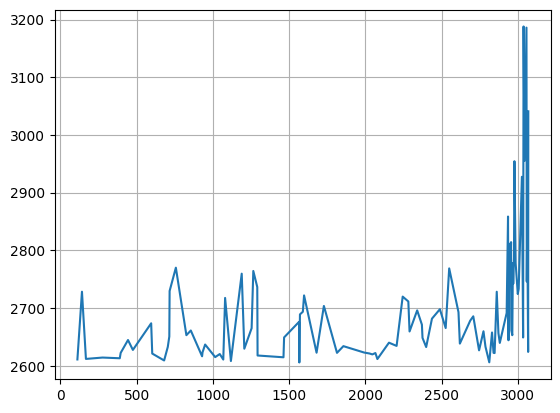

In [75]:
avg_scores = np.array(tot_scores) / np.array(times)

idx_sort = np.argsort(avg_scores)[::-1]

idx_sort = idx_sort[:MAX_POPULATION]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
p_best = ps[0]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

print(population[0].get_id())
print(ids[:10])
print(times[:10])
print(avg_scores[:10])

idx_sort = np.argsort(ids)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
p_last = ps[0]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

import matplotlib.pyplot as plt

x = ids
y = avg_scores
plt.plot(x, y)
plt.grid()
plt.show()



In [76]:
#ThePlayer = population[0]
ThePlayer = p_best
#ThePlayer = p_last

In [77]:
wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

for _ in tqdm(range(n_trials)):
    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player1, player2)

    if winner == 0: wins_first += 1

    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player2, player1)

    if winner == 1: wins_second += 1

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")

100%|██████████| 1000/1000 [00:12<00:00, 83.31it/s]

Player won 906 / 1000 as first
Player won 901 / 1000 as second
